Make depth profiles of ocean velocities in all 10 runs, plus composites. 

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import Functions_data_analysis as fda
import Functions_plotting as fp
from Datasets import exp_set_dict_warm_order
import xarray as xr
import gsw
import sys
import os

In [2]:
# For importing density function
sys.path.append('/glade/u/home/gemmao/MITgcm/utils/python/MITgcmutils/MITgcmutils')
from jmd95 import densjmd95

In [3]:
import importlib
importlib.reload(fp)

<module 'Functions_plotting' from '/glade/campaign/univ/uwas0134/Gemma/Analysis/Final Submission Figs/Functions_plotting.py'>

In [14]:
ic_str = 'moderate' #moderate, warm, cool
region = 'ET_2'
# region = 'lat_5'

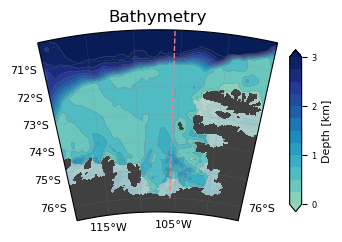

In [5]:
# bathy_map = fp.plot_bathymetry_and_locs('bathy_map', [region,'ET_2'])
bathy_map = fp.plot_bathymetry_and_locs('bathy_map', ['ET_2'])
# plt.savefig('Plots/Figure_S5_bathymetry_map_with_loc.png',dpi=400)

In [15]:
# Ocean T, S, U
exp_set_dict = {'moderate':'ic_2001','warm':'ic_1995','cool':'ic_2008'}
exp_set = exp_set_dict[ic_str]
region_dict = {'ET_2':'105.7W','lat_5':'75.4S'}
region_str = region_dict[region]

prefix = 'state_3d_set2' # To plot ocean T, U, or V at a given depth
runs = exp_set_dict_warm_order[exp_set]
print(runs)
save_new_ens_da = True 

vars = ['T','S','U','V'] # all analyses follow this order
all_run_da_list = []
for var in vars:
    fname = 'Submission Data/Simulated_transect_data/'+var+'_'+region_str+'_'+ic_str+'_ic.nc'
    try:
        all_run_da = xr.open_dataset(fname)[var]
        print(fname,'found')
    except:
        print('creating new .nc file for',var)
        all_run_da = fda.get_ensemble_data_for_ic(var, runs, region, prefix, month_start_idx = 0, n_months=60)
        var_ds = all_run_da.to_dataset(name=var)
        var_ds.to_netcdf(fname)
        print('Saved as',fname)
    
    # these have shape (10 runs, 60 times, 70 depths, 256 lats)
    all_run_da_list.append(all_run_da)

print('Data retrieved!')

['run_forc_erai_1982_rep_ic_2001', 'run_forc_erai_1984_rep_ic_2001', 'run_forc_erai_1989_rep_ic_2001', 'run_forc_erai_1992_rep_ic_2001', 'run_forc_erai_1994_rep_ic_2001', 'run_forc_erai_2003_rep_ic_2001', 'run_forc_erai_2009_rep_ic_2001', 'run_forc_erai_1991_rep_ic_2001', 'run_forc_erai_2015_rep_ic_2001', 'run_forc_erai_2011_rep_ic_2001']
Submission Data/Simulated_transect_data/T_105.7W_moderate_ic.nc found
Submission Data/Simulated_transect_data/S_105.7W_moderate_ic.nc found
Submission Data/Simulated_transect_data/U_105.7W_moderate_ic.nc found
Submission Data/Simulated_transect_data/V_105.7W_moderate_ic.nc found
Data retrieved!


In [16]:
# Calculate annual avgs, ens mean for each yr, and calculate warm/cool composites in anomalies

#order of list = (T,S,U). each item (for T, s, or U) has shape (5 yrs, lons, lats)
ens_mean_list = [] 
warm_list = []
warm_anom_list = [] 
cool_list = []
cool_anom_list = []

for i in range(len(vars)):

    # Load variable data: (10 runs, 60 times, depths, lats) 
    var_i_data = all_run_da_list[i]

    # avg over time for each yr: (10, 60, depths, lats) -> (10, 5, depths, lats)
    var_all_run_ann_mean = var_i_data.resample(time='12M').mean(dim='time')

    # calculate ens means of annual avgs: (10, 5, lons, lats) -> (5 yrs, lons, lats)
    var_ens_mean = var_all_run_ann_mean.mean(dim='run')
    ens_mean_list.append(var_ens_mean) 

    # calculate composites: (10 runs, 5 yrs, depths, lats) -> (5 yrs, depths, lats)
    var_warm_comp_runs = var_all_run_ann_mean.isel(run = slice(0,4))
    var_warm_comp = var_warm_comp_runs.mean(dim='run')
    var_cool_comp_runs = var_all_run_ann_mean.isel(run = slice(4,8))
    var_cool_comp = var_cool_comp_runs.mean(dim='run')
    warm_list.append(var_warm_comp)
    cool_list.append(var_cool_comp)
    if i == 0:
        print('Warm composite runs:',var_warm_comp_runs.run.values)
        print('Cool composite runs:',var_cool_comp_runs.run.values)

    # Put composites in anomalies: (5 yrs, depths, lats)
    var_warm_anom = var_warm_comp - var_ens_mean
    var_cool_anom = var_cool_comp - var_ens_mean

    warm_anom_list.append(var_warm_anom)
    cool_anom_list.append(var_cool_anom)


Warm composite runs: ['run_forc_erai_1982_rep_ic_2001' 'run_forc_erai_1984_rep_ic_2001'
 'run_forc_erai_1989_rep_ic_2001' 'run_forc_erai_1992_rep_ic_2001']
Cool composite runs: ['run_forc_erai_1994_rep_ic_2001' 'run_forc_erai_2003_rep_ic_2001'
 'run_forc_erai_2009_rep_ic_2001' 'run_forc_erai_1991_rep_ic_2001']


In [17]:
# Ensemble mean density
em_temp = ens_mean_list[0].mean(dim = 'time') #(70 depths, 256 lats)
em_sal = ens_mean_list[1].mean(dim = 'time') #(70,256)
em_temp_masked = em_temp.where(em_temp != 0)
em_sal_masked = em_sal.where(em_sal != 0)
em_dens = densjmd95(em_sal_masked, em_temp_masked, 0) - 1000


# get warm density
warm_temp = warm_list[0] #(70 depths, 256 lats)
warm_sal = warm_list[1]#(70,256)
warm_temp_masked = warm_temp.where(warm_temp != 0)
warm_sal_masked = warm_sal.where(warm_sal != 0)
# Get Warm composite density each year
warm_dens_all_yrs = []
for year in range(6):
    warm_dens_year = densjmd95(warm_sal_masked[year], warm_temp_masked[year], 0) - 1000
    warm_dens_all_yrs.append(warm_dens_year)

# get cool density
cool_temp = cool_list[0] #(70 depths, 256 lats)
cool_sal = cool_list[1]#(70,256)
cool_temp_masked = cool_temp.where(cool_temp != 0)
cool_sal_masked = cool_sal.where(cool_sal != 0)
# Get cool composite density each year
cool_dens_all_yrs = []
for year in range(6):
    cool_dens_year = densjmd95(cool_sal_masked[year], cool_temp_masked[year], 0) - 1000
    cool_dens_all_yrs.append(cool_dens_year)
    

In [18]:
def plot_TSU_5_ens_mean(data_list, vnames, profile_type, contour_data_list = None, contour_lev = None, fig_name = None):
    """
    Plot 3 columns  of T, S, U data for ens mean
    Option to plot contour line on top.
    
    Inputs
    ------
    data_list: list of 3 items containing a 3d xr data array 
        order of list = T, S, U
        each list item contains 3d data (shape years, depths, lats or lons) to be plot in colors
    vnames: list of 3 str
        variables being plotted, corresponding to units dic
        order T, S, U
    profile_type: str
        'meridional' or "zonal" cross section
    contour_data_list: list of 3 items containing 3d np or data array (optional)
        contains 3d data (years, depth lats or lons) to plot 1 contour line (e.g. density)
        use None if no contours to plot
    contour_lev: list of floats, optional
        contains 3 items, with None if no contour data to plot, float for contour level to plot
    fig_name: None or str, optional
        str containing fname for saving figure
    
    """

    # set up plotting meta data
    units_dict = {'T':'Pot. Temp [°C]',\
                  'T anomaly':'Pot. Temp anomaly[°C]',\
                  'S':'Salinity [psu]',\
                  'S anomaly':'Salinity anomaly [psu]',\
                  'U':r'U [m s$^{-1}$]','U anomaly':'U anomaly [m/s]'}
    cmap_dict = {'U':'BrBG_r','T':'RdBu_r','S':'YlGnBu'}
    levs_dict = {'T': np.linspace(-1.5,1.5,11),
                 'T anomaly': np.linspace(-0.4,0.4,9),
                 'S': np.linspace(34.2,34.8,11),
                 'S anomaly': np.arange(-0.07,0.07,0.01),
                 'U': np.linspace(-0.08,0.08,9),
                 'U anomaly': np.linspace(-0.04,0.04,9)}

    # make figure
    fig, axes = plt.subplots(1, 3, figsize=(6.5,1.6), constrained_layout=True)

    for i in range(3):
        vname = vnames[i]
        data_i = data_list[i]
        contour_i = contour_data_list[i]
        cmap = cmap_dict[vname.split(' ')[0]]
        levs = levs_dict[vname]
        
        ax = axes[i]

        # Mask data where 0 (model uses 0s instead of nans) and get x/y data
        data_i_mask = data_i.where(data_i.values != 0) 
        try:
            x_data = data_i['lat'].values
        except:
            x_data = data_i['lon'].values
        y_data = data_i.depth.values
        
        # Plot data as filled contours
        cf = ax.contourf(x_data, y_data, data_i_mask, levs, cmap=cmap, extend='both')
        
        # Plot contours
        if contour_i is not None:
            cp = ax.contour(x_data,y_data,contour_i,[contour_lev[i],],colors='k',linewidths=1)
            ax.clabel(cp, inline=True, fontsize=5)
        if i == 0:
            ax.set_ylabel('Depth [m]',fontsize=8)
        ax.set_yticks(np.linspace(-1200,0,4))
        if i != 0:
            ax.set_yticklabels([])
        if profile_type == 'meridional':
            ax.set_xlabel('Latitude',fontsize=8)
        else:
            ax.set_xlabel('Longitude',fontsize=8)
            
        # Add colorbar 
        cb = fig.colorbar(cf, extend='both',orientation = 'horizontal',location='bottom',shrink=1,pad=0.1)
        cb.set_label(units_dict[vname],fontsize=8)
        cb.ax.tick_params(labelsize=5)
        cb.set_ticks(levs)
        if i == 1:
            cb.set_ticks(levs[::2])

    for ax in axes.flat:
        ax.set_ylim([-1200,0])
        ax.set_facecolor('darkgray')
        ax.tick_params(axis='both', which='both', labelsize=6)
        if profile_type == 'meridional':
            ax.set_xlim([-75.8,-70.5])
            ax.set_xticks(np.arange(-75,-70,1))
        else:
            ax.set_xlim([-110.2,-98])
            ax.set_xticks(np.arange(-110,-96,2))

    if fig_name is not None:
        plt.savefig(fig_name,dpi=800)
        print('saving as',fig_name)

    return

saving as Plots/Figure_3_abc_TSU_em.png


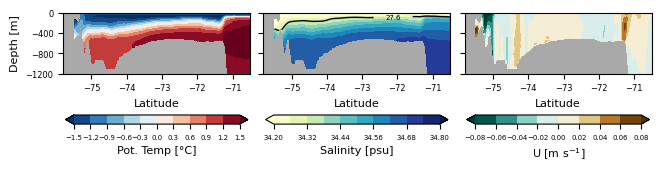

In [19]:
# Plot ens means
fig_name = 'Plots/Figure_3_abc_TSU_em.png'
# fig_name = None
em_T_time_avg = ens_mean_list[0].mean(dim='time')
em_S_time_avg = ens_mean_list[1].mean(dim='time')
em_U_time_avg = ens_mean_list[2].mean(dim='time')
em_data_list = [em_T_time_avg, em_S_time_avg, em_U_time_avg]
plot_TSU_5_ens_mean(em_data_list, ['T','S','U',], 'meridional', contour_data_list = [None, em_dens, None], contour_lev = [None,27.6,None], fig_name = fig_name)

In [20]:
def plot_TSU_5_years(data_list, vnames, profile_type, contour_data_list = None, contour_lev = None, fig_name = None):
    """
    Plot 3 columns and 5 rows of T, S, U data for warm comp or cool composite
    Either for anomalies or actual values
    Option to plot contour line on top.
    
    Inputs
    ------
    data_list: list of 3 items containing a 3d xr data array 
        order of list = T, S, U
        each list item contains 3d data (shape years, depths, lats or lons) to be plot in colors
    vnames: list of 3 str
        variables being plotted, corresponding to units dic
        order T, S, U
    profile_type: str
        'meridional' or "zonal" cross section
    contour_data_list: list of 3 items containing 3d np or data array (optional)
        contains 3d data (years, depth lats or lons) to plot 1 contour line (e.g. density)
        use None if no contours to plot
    contour_lev: list of floats, optional
        contains 3 items, with None if no contour data to plot, float for contour level to plot
    fig_name: None or str, optional
        str containing fname for saving figure
    
    """

    # set up plotting meta data
    units_dict = {'T':'Pot. Temp [°C]',\
                  'T anomaly':'Pot. Temp anomaly [°C]',\
                  'S':'Salinity [psu]',\
                  'S anomaly':'Salinity anomaly [psu]',\
                  'U':r'U [m s$^{-1}$]','U anomaly':r'U anomaly [m s$^{-1}$]'}
    cmap_dict = {'U':'BrBG_r','T':'RdBu_r','S':'YlGnBu'}
    levs_dict = {'T': np.linspace(-1.5,1.5,11),
                 'T anomaly': np.linspace(-0.4,0.4,17),
                 'S': np.linspace(34.2,34.8,11),
                 'S anomaly': np.arange(-0.07,0.07,0.01),
                 'U': np.linspace(-0.08,0.08,9),
                 'U anomaly': np.linspace(-0.04,0.04,17)}

    # make figure
    fig, axes = plt.subplots(5, 3, figsize=(6.5,5), constrained_layout=True)

    for i in range(3):
        vname = vnames[i]
        print(vname)
        var_data = data_list[i]
        var_contour_data = contour_data_list[i]
        cmap = cmap_dict[vname.split(' ')[0]]
        levs = levs_dict[vname]
        
        for j in range(5):
            ax = axes[j, i]
    
            # Mask data where 0 (model uses 0s instead of nans) and get x/y data
            data_j = var_data[j]
            data_j_mask = data_j.where(data_j.values != 0) 
            try:
                x_data = data_j['lat'].values
            except:
                x_data = data_j['lon'].values
            y_data = data_j.depth.values
            
            # Plot data as filled contours
            cf = ax.contourf(x_data, y_data, data_j_mask, levs, cmap=cmap, extend='both')
            
            # if T_Data, Plot T data as contours ontop of filled contour plot
            if var_contour_data is not None:
                contour_j = var_contour_data[j]
                cp = ax.contour(x_data,y_data,contour_j,[contour_lev[i],],colors='k',linewidths=1)
                # ax.clabel(cp, inline=False, fontsize=7)
            if i == 0 and j == 2:
                ax.set_ylabel('Depth [m]',fontsize=8)
            ax.set_yticks(np.linspace(-1200,0,4))
            if i == 0:
                ax.annotate('Year '+str(j+1),(0.02,0.05),xycoords='axes fraction',fontsize=7,fontweight='bold')
            else:
                ax.set_yticklabels([])
            if j == 4:
                if profile_type == 'meridional':
                    ax.set_xlabel('Latitude',fontsize=8)
                else:
                    ax.set_xlabel('Longitude',fontsize=8)
                # Add colorbar 
                cb = fig.colorbar(cf, extend='both',orientation = 'horizontal',location='bottom',shrink=1,pad=0.1)
                cb.set_label(units_dict[vname],fontsize=8)
                cb.ax.tick_params(labelsize=5)
                cb.set_ticks(levs)
                cb.set_ticks(levs[::2])
            else:
                ax.set_xticklabels([])

    for ax in axes.flat:
        # cb.set_ticks(levs[::2])
        ax.set_ylim([-1200,0])
        ax.set_facecolor('darkgray')
        ax.tick_params(axis='both', which='both', labelsize=6)
        if profile_type == 'meridional':
            ax.set_xlim([-75.8,-70.5])
            ax.set_xticks(np.arange(-75,-70,1))
        else:
            ax.set_xlim([-110.2,-98])
            ax.set_xticks(np.arange(-110,-96,2))

    if fig_name is not None:
        plt.savefig(fig_name,dpi=800)
        print('saving as',fig_name)

    return

T anomaly
S anomaly
U anomaly
saving as Plots/Figure_3def_TSU_warm.png


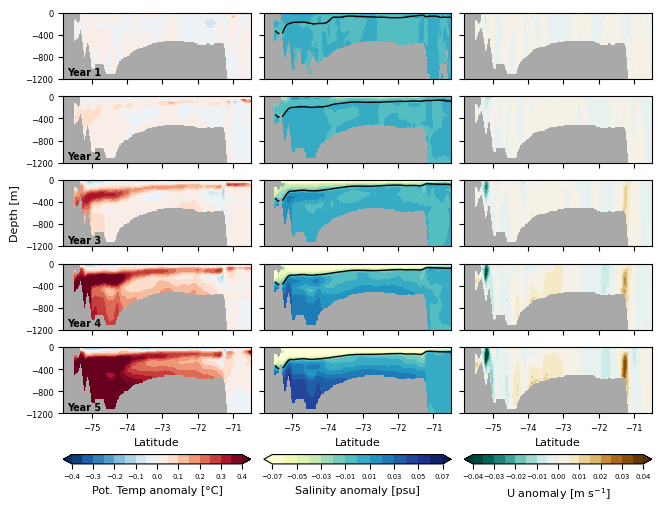

In [21]:
# Plot warm composite anomalies
fig_name = 'Plots/Figure_3def_TSU_warm.png'
# fig_name = None
plot_TSU_5_years(warm_anom_list, ['T anomaly','S anomaly','U anomaly'], 'meridional', 
                 contour_data_list = [None, warm_dens_all_yrs, None], contour_lev = [None,27.6,None],
                 fig_name = fig_name)

T anomaly
S anomaly
U anomaly
saving as Plots/Figure_S4_TSU_cool.png


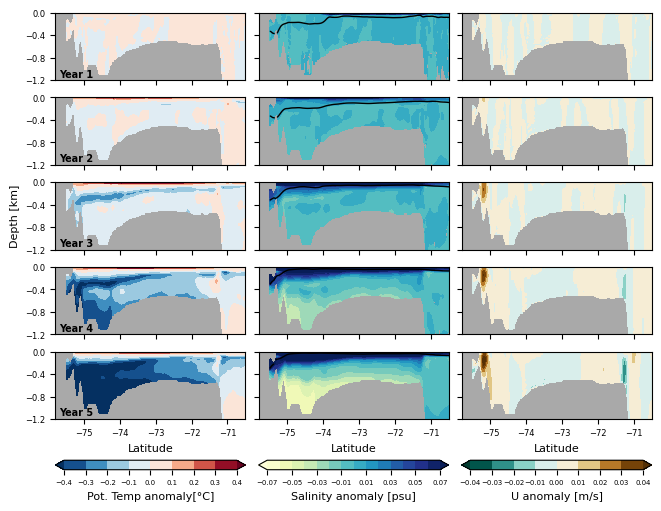

In [20]:
# Plot cool composite anomalies
plot_TSU_5_years(cool_anom_list, ['T anomaly','S anomaly','U anomaly'], 'meridional', 
                 contour_data_list = [None, cool_dens_all_yrs, None], contour_lev = [None,27.6,None], 
                 fig_name = 'Plots/Figure_S4_TSU_cool.png')

T
S
U
saving as Plots/Figure_S5a_TSU_warm_actual_values.png


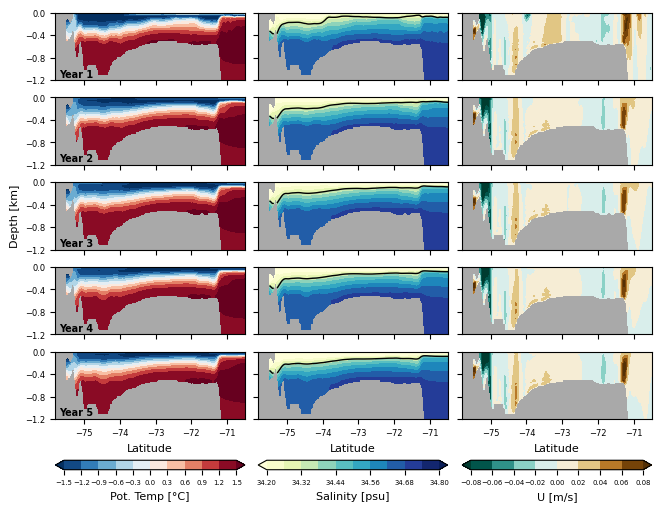

In [31]:
# Plot warm composite actual values
fig_name = 'Plots/Figure_S5a_TSU_warm_actual_values.png'
# fig_name = None
plot_TSU_5_years(warm_list, ['T','S','U'], 'meridional', 
                 contour_data_list = [None, warm_dens_all_yrs, None], contour_lev = [None,27.6,None], 
                 fig_name = fig_name)

T
S
U
saving as Plots/Figure_S5b_TSU_cool_actual_values.png


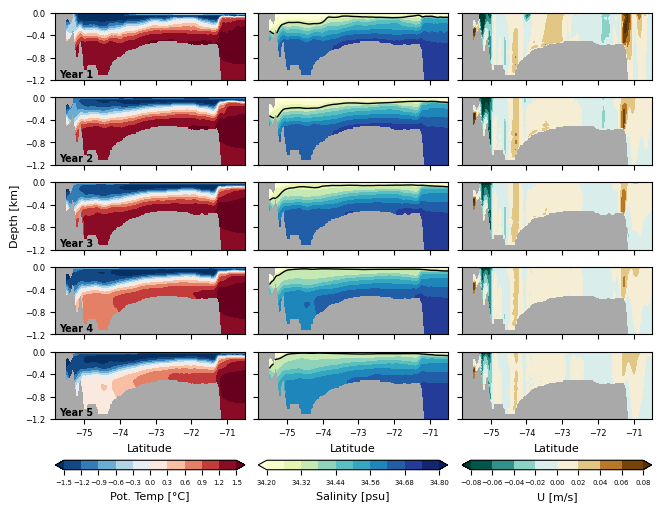

In [32]:
# Plot cool composite actual values
fig_name = 'Plots/Figure_S5b_TSU_cool_actual_values.png'
# fig_name = None
plot_TSU_5_years(cool_list, ['T','S','U'], 'meridional', 
                 contour_data_list = [None, cool_dens_all_yrs, None], contour_lev = [None,27.6,None], 
                 fig_name = fig_name)